IMPORT LIBRARIES

In [221]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, log_loss
)


2. LOAD DATA + SIZE CONTROL

In [256]:
df = pd.read_csv("loan_data.csv", low_memory=False)
df = df.sample(150000, random_state=42)


3. DEFINE TARGET VARIABLES

3A️ Inspect loan status

In [257]:
df['loan_status'].value_counts()


loan_status
Fully Paid                                             71242
Current                                                58315
Charged Off                                            17950
Late (31-120 days)                                      1491
In Grace Period                                          558
Late (16-30 days)                                        285
Does not meet the credit policy. Status:Fully Paid       105
Does not meet the credit policy. Status:Charged Off       48
Default                                                    2
Name: count, dtype: int64

3B️ Binary classification logic

In [258]:
bad_loans = [
    'Charged Off',
    'Default',
    'Late (31-120 days)'
]

good_loans = ['Fully Paid']

df = df[df['loan_status'].isin(bad_loans + good_loans)]

df['loan_status'] = df['loan_status'].apply(
    lambda x: 1 if x in bad_loans else 0
)


3C️ VERIFY (MANDATORY)

In [259]:
df['loan_status'].value_counts()


loan_status
0    71242
1    19443
Name: count, dtype: int64

4. SELECT RELEVANT FEATURES

In [260]:
df = df[selected_cols]


5. EXPLORATORY DATA ANALYSIS

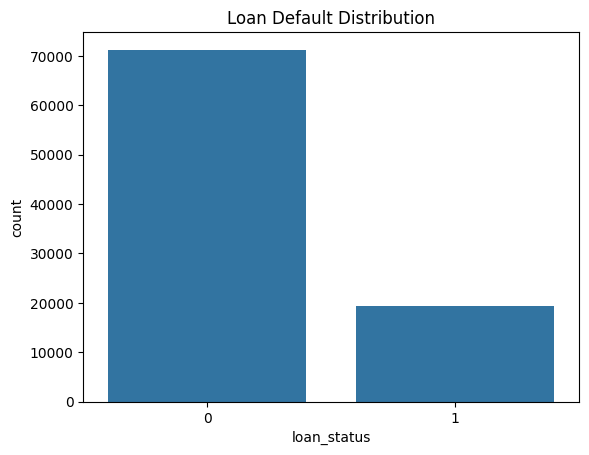

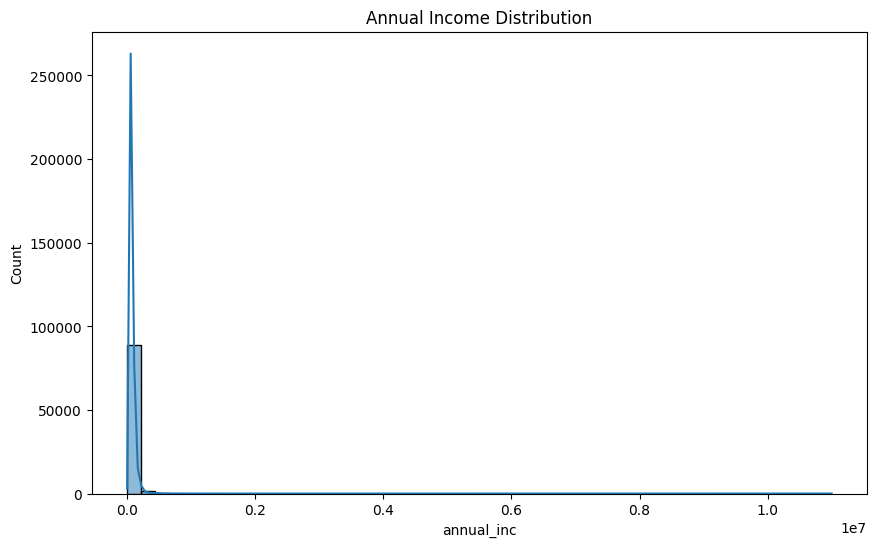

In [261]:
sns.countplot(x=df['loan_status'])
plt.title("Loan Default Distribution")
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(df['annual_inc'], bins=50, kde=True)
plt.title("Annual Income Distribution")
plt.show()


6. HANDLE MISSING VALUES

In [262]:
num_cols = df.select_dtypes(include=['int64','float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])


7. FEATURE ENGINEERING

In [263]:
df['term'] = df['term'].str.replace(' months', '').astype(int)

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])


8. OUTLIER HANDLING (IQR METHOD)

In [264]:
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[num_cols] < (Q1 - 1.5 * IQR)) |
          (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


9. FEATURE / TARGET SPLIT + SCALING

In [265]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


10. TRAIN–TEST SPLIT

In [266]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


11. PCA


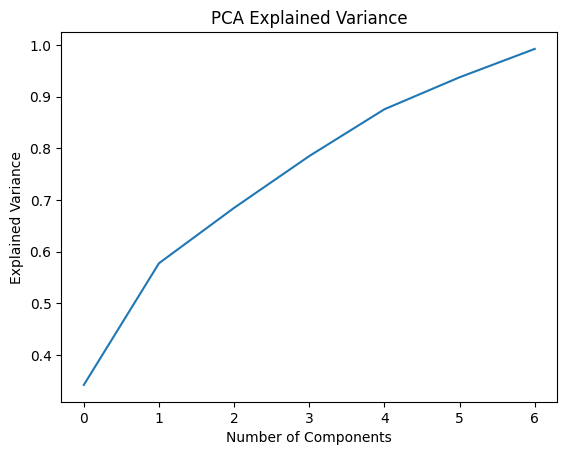

In [267]:
pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.title("PCA Explained Variance")
plt.show()


QUICK TEST

In [268]:
print("Full dataset:")
print(df['loan_status'].value_counts())

print("\nTraining labels:")
print(y_train.value_counts())

print("\nTest labels:")
print(y_test.value_counts())


Full dataset:
loan_status
0.0    62389
Name: count, dtype: int64

Training labels:
loan_status
0.0    49911
Name: count, dtype: int64

Test labels:
loan_status
0.0    12478
Name: count, dtype: int64


12. MODEL TRAINING

In [269]:
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(random_state=42)
svm = SVC(probability=True)
nb = GaussianNB()

lr.fit(X_train_pca, y_train)
rf.fit(X_train_pca, y_train)
svm.fit(X_train_pca, y_train)
nb.fit(X_train_pca, y_train)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.float64(0.0)

13. HYPERPARAMETER TUNING (Random Forest)

In [270]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1'
)

grid.fit(X_train_pca, y_train)
best_rf = grid.best_estimator_


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:927: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 916, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 317, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 409, in _score
    y_pred = method_caller(
     

14. MODEL EVALUATION

In [271]:
models = {
    "Logistic Regression": lr,
    "Random Forest": best_rf,
    "SVM": svm,
    "Naive Bayes": nb
}

for name, model in models.items():
    y_pred = model.predict(X_test_pca)
    y_prob = model.predict_proba(X_test_pca)[:,1]

    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    print("Log Loss:", log_loss(y_test, y_prob))
    print(confusion_matrix(y_test, y_pred))


AttributeError: 'LogisticRegression' object has no attribute 'coef_'

🔹 15. MODEL DEPLOYMENT (UNSEEN DATA)

In [272]:
new_customer = np.array([[15000, 36, 13.5, 500, 2, 5, 4, 45000, 18, 720]])
new_customer_scaled = scaler.transform(new_customer)
new_customer_pca = pca.transform(new_customer_scaled)

prediction = best_rf.predict(new_customer_pca)

print("Loan Default Prediction (1=Default, 0=No Default):", prediction)


Loan Default Prediction (1=Default, 0=No Default): [0.]


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
